# Clustering Abstract for 2010-2011

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import expr   
from pyspark.sql.functions import udf

from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StopWordsRemover

import matplotlib.pyplot as plt

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler
from pyspark.sql.functions import col

from pyspark.ml.feature import Word2Vec

#create a Spark application
spark = SparkSession.builder.enableHiveSupport().appName('eda').getOrCreate()
sc = spark.sparkContext
#spark.debug.maxToStringFields=60

#from pyspark.conf import SparkConf
spark.conf.set("spark.sql.debug.maxToStringFields", 500)

spark.sparkContext.uiWebUrl

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.app.id', 'application_1677993247704_0002'),
 ('spark.executor.memory', '5739m'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.driver.appUIAddress',
  'http://hub-hub-msca-bdp-dphub-student-dhruvs-m.c.msca-bdp-student-ap.internal:46713'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.dataproc.sql.optimizer.leftsemijoin.conversion.enabled', 'true'),
 ('spark.hadoop.hive.execution.engine', 'mr'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),
 (

In [3]:
df = spark.read.parquet('gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_par.parquet')

In [4]:
df_new = df.select(df.fos[0].getItem('name'), df.authors[0].getItem('name'), df.abstract, df.title, df.year)

df_new = df_new.withColumnRenamed("fos[0].name","category")\
    .withColumnRenamed("authors[0].name","author_name")

df_new = df_new.dropna()

In [5]:
year_list = [2010,2011]
df_read = df_new.filter(df_new.year.isin(year_list)) #count = 2235775
df_read = df_read.dropna()


In [6]:
df_read.count()

363061

### Clean abstract

In [7]:
#removing rows where abstract is empty

df_read = df_read.filter("abstract != ''")

df_read = df_read.filter(trim(col("abstract")) != "null")

#remove all the abstracts which are duplicate
abstracts_to_remove = df_read.groupBy("abstract").count().orderBy(col("count")).filter(col("count")>1)
abstracts_remove_list = abstracts_to_remove.rdd.map(lambda x: x[0]).collect()
df_read = df_read.filter(~df_read.abstract.isin(abstracts_remove_list))

#trim whitespace
df_read = df_read.withColumn("abstract", trim(df.abstract))
#remove redundant space between words
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "\s+", " "))
#remove punctuation marks
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "[^\\w\\s]+", ""))

In [8]:
df_read.count()

316826

### Tokenize and Stop Words

In [9]:
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
df_read = tokenizer.transform(df_read)
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_read = remover.transform(df_read)

#drop the redundant source column
df_read= df_read.drop("words")

In [11]:
df_read.show(10)

+--------------------+-----------------+--------------------+--------------------+----+--------------------+
|            category|      author_name|            abstract|               title|year|            filtered|
+--------------------+-----------------+--------------------+--------------------+----+--------------------+
|    Mobile computing|       Ercan Ucan|We present an app...|Dexferizer: a ser...|2011|[present, approac...|
|Discrete mathematics|Ulrich Kohlenbach|We prove a result...|A note on the mon...|2011|[prove, result, r...|
|         False alarm|       YuLong Zou|In cognitive radi...|A Cooperative Spe...|2011|[cognitive, radio...|
| Description section|      Eva D'hondt|In this paper we ...|Combining Documen...|2011|[paper, report, p...|
|Discrete mathematics|     Syh-Yuan Tan|We present a Java...|Java implementati...|2010|[present, java, i...|
|   Computer security|      Sandy Clark|Work on security ...|Familiarity breed...|2010|[work, security, ...|
| Workflow technolo

### Vectorize

In [12]:
vec_size = 50
word2Vec = Word2Vec(vectorSize=vec_size, minCount=0, inputCol="filtered", outputCol="wordVectors")

In [ ]:
w2VM = word2Vec.fit(df_read)
nlpdf = w2VM.transform(df_read)
nlpdf.select(col("wordVectors")).show()

In [16]:
from pyspark.ml.functions import vector_to_array
nlpdf_new = nlpdf.withColumn("vec", vector_to_array("wordVectors")).select(["category", "author_name", "year"] + [col("vec")[i] for i in range(vec_size)])
nlpdf_new.printSchema()

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

### Calculating the Silhouette Score

In [17]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler

column_names = []
for i in range (vec_size):
    col_name = "vec[{}]".format(i)
    column_names.append(col_name)

vecAssembler = VectorAssembler(inputCols = column_names, outputCol="features")
new_df = vecAssembler.transform(nlpdf_new)

In [18]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(new_df)

    KMeans_transform=KMeans_fit.transform(new_df) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)
    

Text(0, 0.5, 'Silhouette Score')

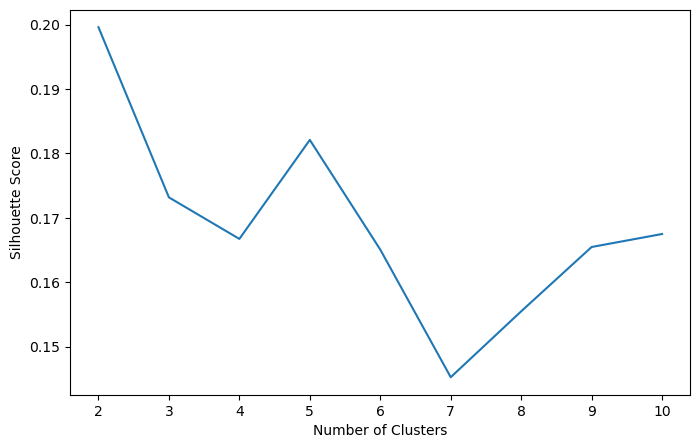

In [19]:
fig, ax = plt.subplots(1,1, figsize =(8,5))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

### Clustering

In [20]:
from pyspark.ml.clustering import KMeans
num_clusters = 7
kmeans = KMeans(k=num_clusters, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)
transformed.select(col("prediction")).show(10)

+----------+
|prediction|
+----------+
|         0|
|         5|
|         4|
|         2|
|         1|
|         0|
|         3|
|         6|
|         3|
|         5|
+----------+
only showing top 10 rows



### Group by caategory and cluster prediction

In [21]:
transformed.printSchema()
df_agg = transformed.groupBy("category", "prediction").count()
df_agg.show(10)

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

+--------------------+----------+-----+
|            category|prediction|count|
+--------------------+----------+-----+
|    Slavic languages|         2|    1|
|    Speech synthesis|         3|   23|
|   Computer security|         1|    5|
|         Reservation|         4|   82|
|Automotive engine...|         0|   53|
|  Volume ray casting|         0|    2|
|   Cross-correlation|         6|   29|
|Electromagnetical...|         6|    3|
|             Prosody|         2|   88|
| Statistical physics|         1|  324|
+--------------------+----------+-----+
only showing top 10 rows



### Get top 5 categories in each cluster

In [22]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window = Window.partitionBy(df_agg['prediction']).orderBy(df_agg['count'].desc())
df_short = df_agg.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 5) 

In [23]:
df_short.show(100)

+--------------------+----------+-----+----+
|            category|prediction|count|rank|
+--------------------+----------+-----+----+
|Mathematical opti...|         1| 5508|   1|
|Discrete mathematics|         1| 3066|   2|
|Convergence (rout...|         1| 2382|   3|
|Particle swarm op...|         1|  921|   4|
|        Econometrics|         1|  833|   5|
|     Computer vision|         6| 1553|   1|
|    Computer science|         6|  848|   2|
|      Control theory|         6|  805|   3|
|Biomedical engine...|         6|  621|   4|
|         Meteorology|         6|  449|   5|
|    Computer science|         3| 2314|   1|
|      World Wide Web|         3| 1987|   2|
|        Data science|         3| 1846|   3|
|         Data mining|         3| 1808|   4|
|  Information system|         3| 1662|   5|
|Discrete mathematics|         5| 4368|   1|
|             Integer|         5|  758|   2|
|               Graph|         5|  252|   3|
|       Combinatorics|         5|  228|   4|
|        G

In the table above, we can see that categories in clusters are more diverse. We can see Ontology with Data mining and computer science. We can also see Meteorology and Biomedical Engineering with Computer Vision. We can also see Econometrics with optimization and convergence. These results are what we expected. With time, the fields we initially thought are diverse have started interacting with each other. 

### Save result

In [ ]:
df_short.write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2010_short.csv")
df_agg.write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2010_agg.csv")

In [25]:
df_read_after = spark.read.csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2010_short.csv", inferSchema=True, header=True)

In [26]:
df_read_after.show(100)

+--------------------+----------+-----+----+
|            category|prediction|count|rank|
+--------------------+----------+-----+----+
|    Wireless network|         4| 1634|   1|
|    Computer science|         4| 1298|   2|
|        Base station|         4|  789|   3|
|Linear network co...|         4|  777|   4|
|Key distribution ...|         4|  769|   5|
|Mathematical opti...|         1| 5508|   1|
|Discrete mathematics|         1| 3066|   2|
|Convergence (rout...|         1| 2382|   3|
|Particle swarm op...|         1|  921|   4|
|        Econometrics|         1|  833|   5|
|         Data mining|         0| 3557|   1|
|    Computer science|         0| 2811|   2|
|    Mobile computing|         0| 1347|   3|
|Programming language|         0| 1204|   4|
|Ontology (informa...|         0| 1081|   5|
|     Computer vision|         2|11144|   1|
|         Data mining|         2| 6790|   2|
|    Computer science|         2| 1799|   3|
|Iterative reconst...|         2| 1092|   4|
| Pattern 